In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import r2_score

import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt

sns.set( rc={'figure.figsize':(16,9)} )

# Choose stocks and market

In [2]:
chosen_ones = [
                'Titan', 'ASIANPAINT',      # Consumer Durables
                'HINDUNILVR', 'ITC',        # FMCG
                'APOLLOHOSP',               # Healthcare
                'HDFCBANK', 'HDFC'          # Financial Services
            ]

index_one = '^NSEI'                         # NIFTY 50

# Download data

In [3]:
history = {}

yf.pdr_override( )
history[index_one] = pdr.get_data_yahoo( index_one, period='3y' ).reset_index( )

good_dates = set( history[index_one]['Date'] )

history[index_one].shape

[*********************100%***********************]  1 of 1 completed


(745, 7)

In [4]:
for ticker in chosen_ones:
    history[ticker] = pdr.get_data_yahoo( ticker + '.NS', period='3y' ).reset_index( )
    print( ticker + ': ' + str( history[ticker].shape ) )

    good_dates = good_dates.intersection( set( history[ticker]['Date'] ) )

[*********************100%***********************]  1 of 1 completed
Titan: (747, 7)
[*********************100%***********************]  1 of 1 completed
ASIANPAINT: (747, 7)
[*********************100%***********************]  1 of 1 completed
HINDUNILVR: (747, 7)
[*********************100%***********************]  1 of 1 completed
ITC: (747, 7)
[*********************100%***********************]  1 of 1 completed
APOLLOHOSP: (747, 7)
[*********************100%***********************]  1 of 1 completed
HDFCBANK: (747, 7)
[*********************100%***********************]  1 of 1 completed
HDFC: (747, 7)


# Get rid of dates with missing data

In [5]:
for key in history.keys( ):
    history[key] = history[key][ history[key]['Date'].isin( good_dates ) ].reset_index( drop=True )
    print( key + ': ' + str( history[key].shape ) )

^NSEI: (745, 7)
Titan: (745, 7)
ASIANPAINT: (745, 7)
HINDUNILVR: (745, 7)
ITC: (745, 7)
APOLLOHOSP: (745, 7)
HDFCBANK: (745, 7)
HDFC: (745, 7)


# Calculate Daily Return

In [6]:
for key in history.keys( ):
    history[key]['Return'] = ( history[key]['Close'] - history[key]['Open'] ) / history[key]['Open']

# Train test split

In [7]:
split_date = history[index_one]['Date'].max( ) - dt.timedelta( days=180 )
split_date

Timestamp('2022-04-10 00:00:00+0530', tz='Asia/Kolkata')

In [8]:
test_history = {}
train_history = {}

for key in history.keys( ):
    train_history[key] = history[key][ history[key]['Date'] < split_date ].copy( )
    test_history[key] = history[key][ history[key]['Date'] >= split_date ].copy( )

# Calculate Expected Return and Standard Deviation

In [9]:
train_exp_return = {}
train_std_return = {}

for key in train_history.keys( ):
    train_exp_return[key] = train_history[key]['Return'].mean( )
    train_std_return[key] = train_history[key]['Return'].std( )

In [10]:
test_exp_return = {}
test_std_return = {}

for key in test_history.keys( ):
    test_exp_return[key] = test_history[key]['Return'].mean( )
    test_std_return[key] = test_history[key]['Return'].std( )

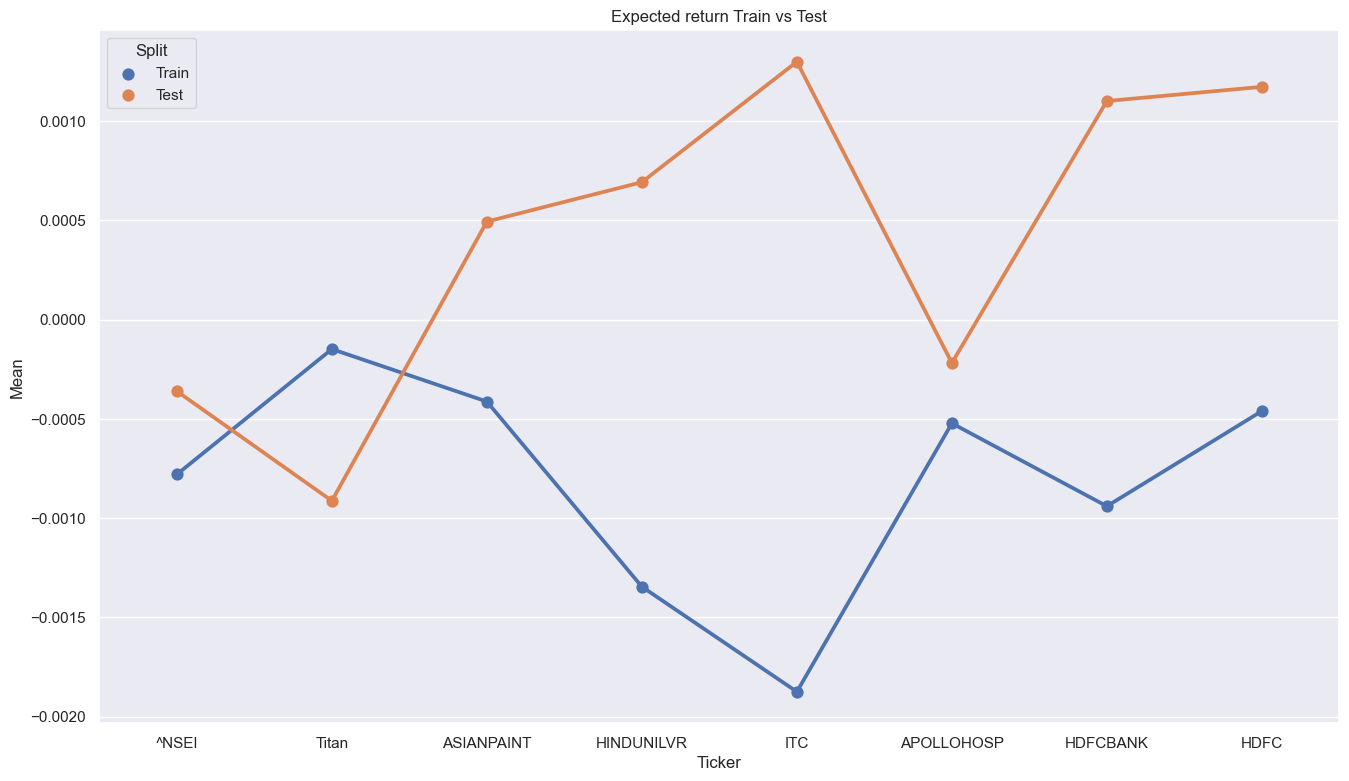

In [11]:
exp_return_graph = pd.concat( [
pd.DataFrame( list( zip( ['Train'] * len( train_exp_return.keys( ) ), train_exp_return.keys( ), train_exp_return.values( ) ) ), columns=['Split', 'Ticker', 'Mean'] ),
pd.DataFrame( list( zip( ['Test'] * len( test_exp_return.keys( ) ), test_exp_return.keys( ), test_exp_return.values( ) ) ), columns=['Split', 'Ticker', 'Mean'] )
] )

fig = sns.pointplot( data=exp_return_graph, x='Ticker', y='Mean', hue='Split' )
plt.title( 'Expected return Train vs Test' )
plt.show( )

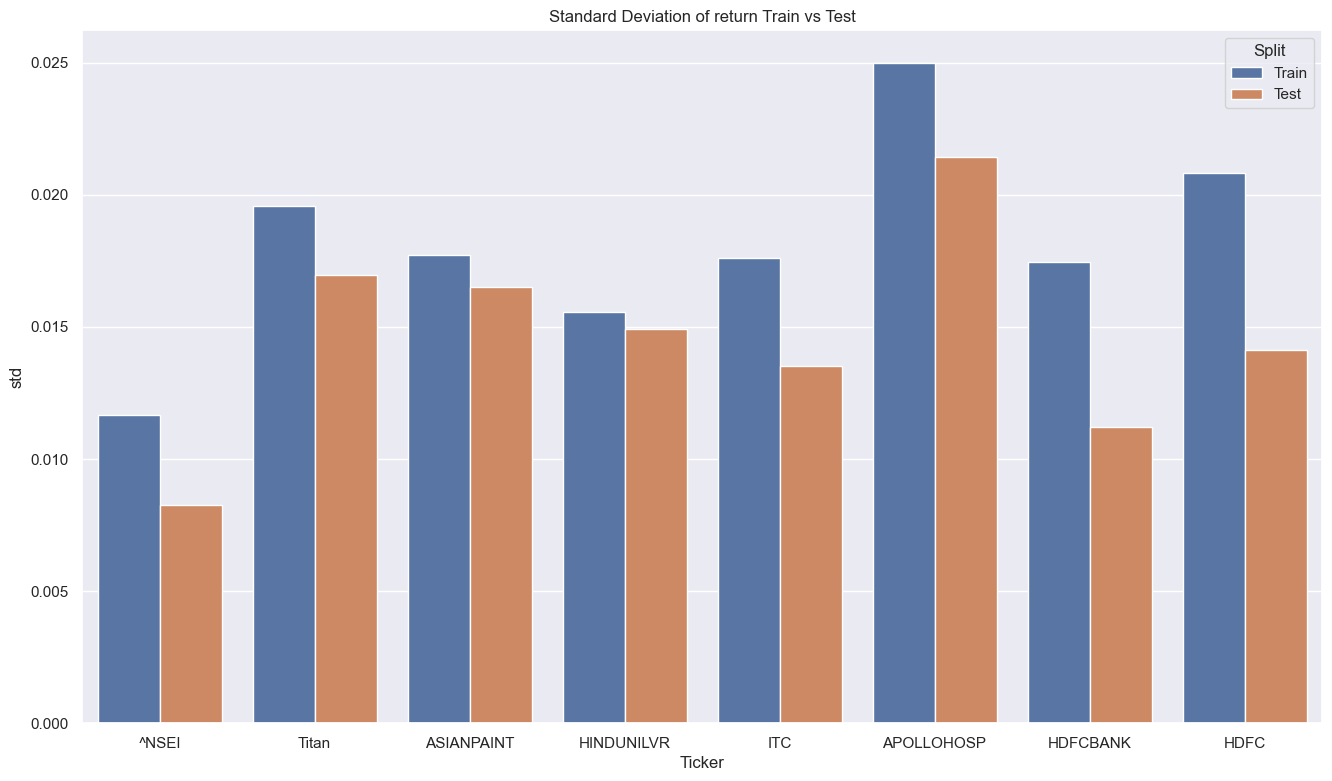

In [12]:
std_return_graph = pd.concat( [
pd.DataFrame( list( zip( ['Train'] * len( train_std_return.keys( ) ), train_std_return.keys( ), train_std_return.values( ) ) ), columns=['Split', 'Ticker', 'std'] ),
pd.DataFrame( list( zip( ['Test'] * len( test_std_return.keys( ) ), test_std_return.keys( ), test_std_return.values( ) ) ), columns=['Split', 'Ticker', 'std'] )
] )

# fig = sns.pointplot( data=std_return_graph, x='Ticker', y='std', hue='Split' )
sns.barplot( data=std_return_graph, x='Ticker', y='std', hue='Split' )
plt.title( 'Standard Deviation of return Train vs Test' )
plt.show( )

# Calculate correlation coefficient for each stock with market

In [13]:
corr_coeff = {}

for stock in chosen_ones:
    corr_coeff[stock] = np.corrcoef( train_history[stock]['Return'], train_history[index_one]['Return'] )[0,1]

In [14]:
corr_coeff

{'Titan': 0.5085953767306066,
 'ASIANPAINT': 0.48948925914315433,
 'HINDUNILVR': 0.4531733820805352,
 'ITC': 0.4219245919459387,
 'APOLLOHOSP': 0.37339601158891356,
 'HDFCBANK': 0.7624193209088592,
 'HDFC': 0.7463751615018194}

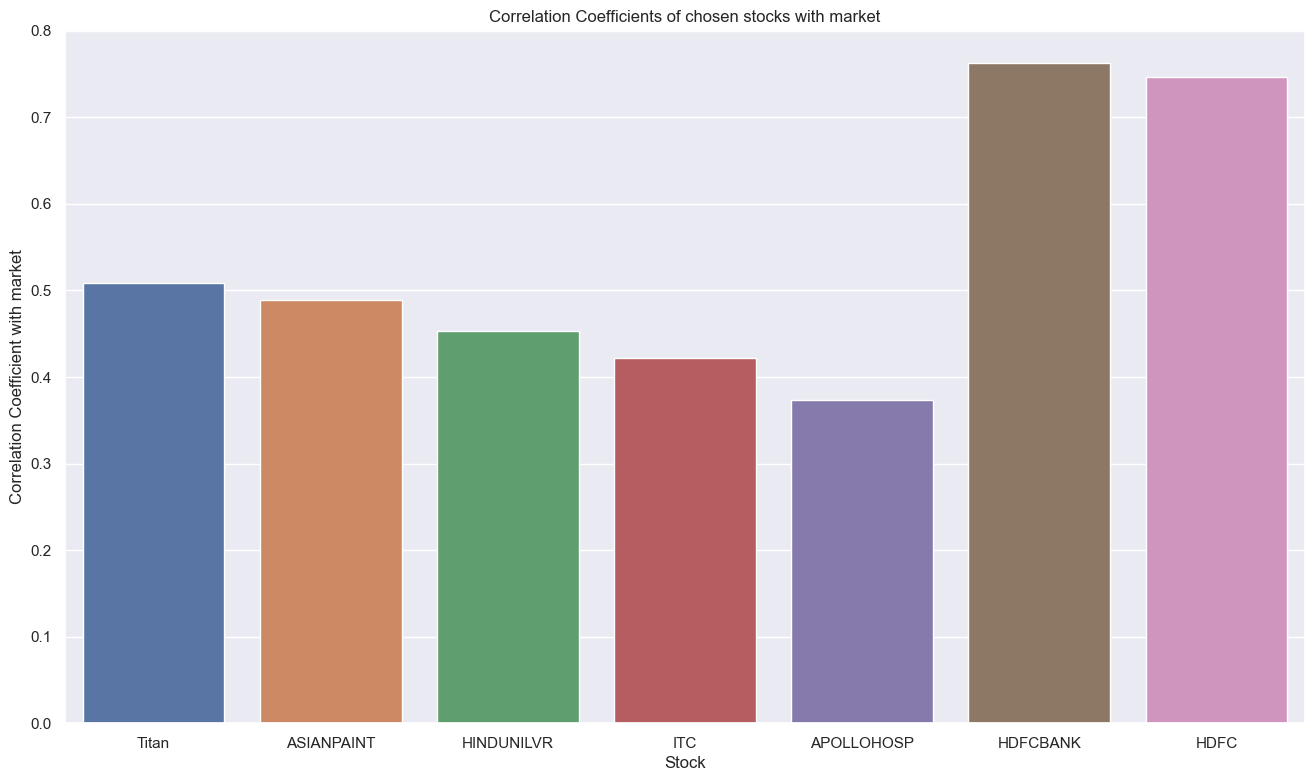

In [15]:
sns.barplot( x=list( corr_coeff.keys( ) ), y=list( corr_coeff.values( ) ) )
plt.xlabel( 'Stock' )
plt.ylabel( 'Correlation Coefficient with market' )
plt.title( 'Correlation Coefficients of chosen stocks with market' )
plt.show( )

# Calculate Beta for each stock

In [16]:
beta = {}

for stock in chosen_ones:
    beta[stock] = corr_coeff[stock] * train_std_return[stock] / train_std_return[index_one]

In [17]:
beta

{'Titan': 0.8529877353093931,
 'ASIANPAINT': 0.7428488060248628,
 'HINDUNILVR': 0.6031397508743914,
 'ITC': 0.635527447916399,
 'APOLLOHOSP': 0.7984099570950105,
 'HDFCBANK': 1.1401386788253707,
 'HDFC': 1.330971745018812}

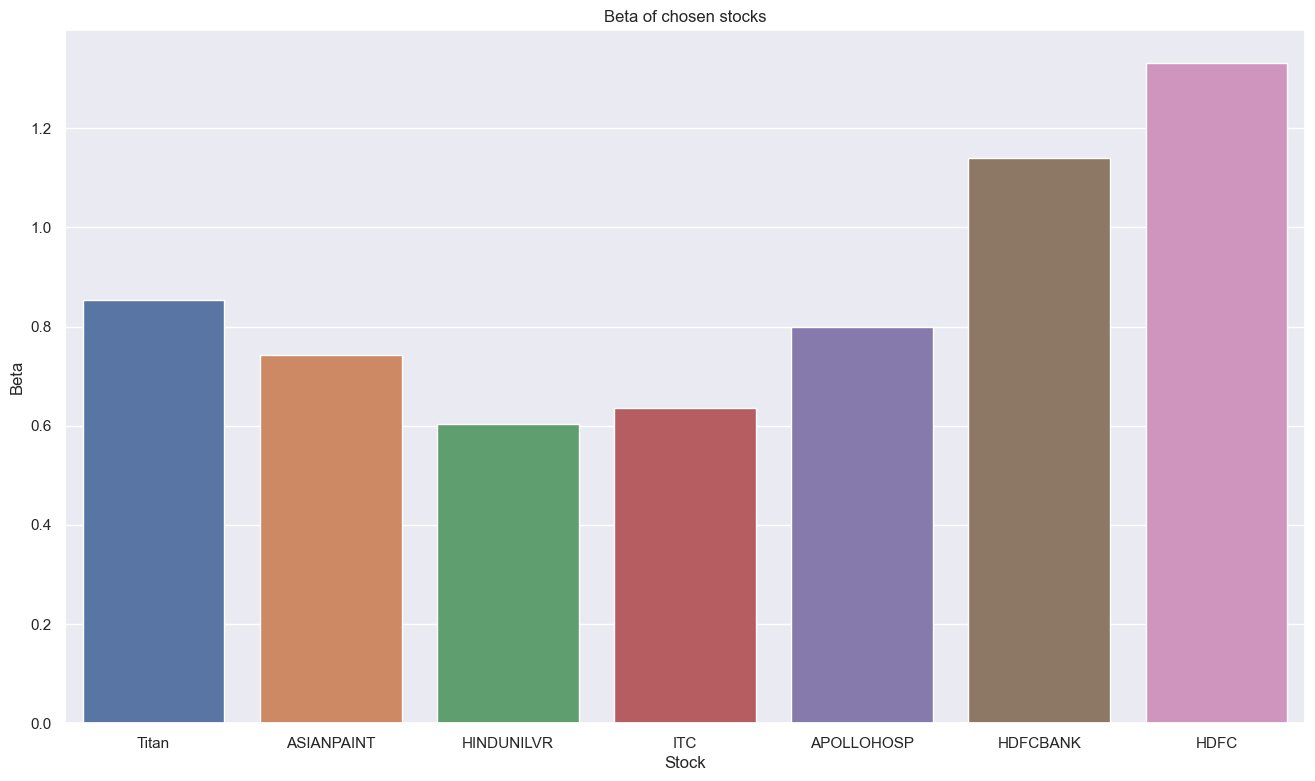

In [18]:
sns.barplot( x=list( beta.keys( ) ), y=list( beta.values( ) ) )
plt.xlabel( 'Stock' )
plt.ylabel( 'Beta' )
plt.title( 'Beta of chosen stocks' )
plt.show( )

# Calculate R2 Score for each stock

In [19]:
r2 = {}

for stock in chosen_ones:
    r2[stock] = r2_score( train_history[stock]['Return'], train_history[index_one]['Return'] )

In [20]:
r2

{'Titan': 0.24994681122713847,
 'ASIANPAINT': 0.21045923008964462,
 'HINDUNILVR': 0.11512690341657172,
 'ITC': 0.11559362921920369,
 'APOLLOHOSP': 0.13042988144408996,
 'HDFCBANK': 0.5724169776033587,
 'HDFC': 0.5223935040333476}

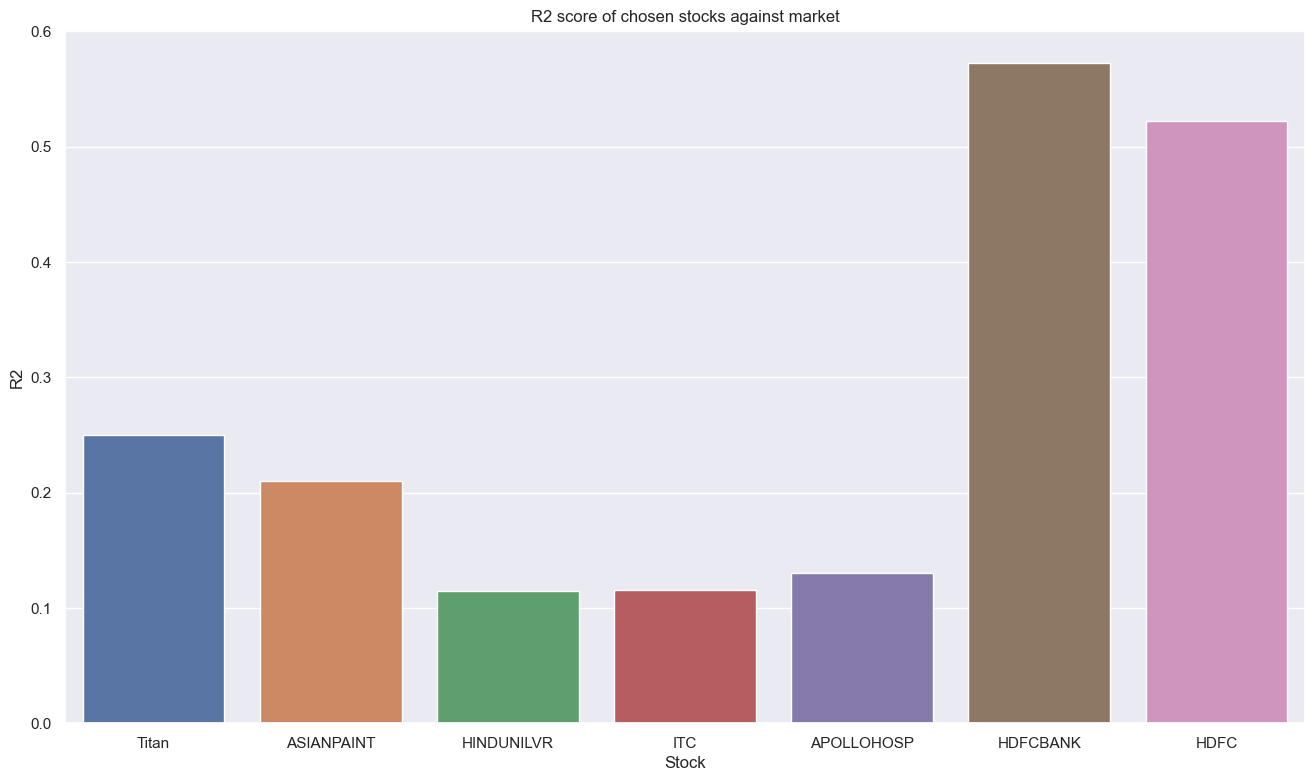

In [21]:
sns.barplot( x=list( r2.keys( ) ), y=list( r2.values( ) ) )
plt.xlabel( 'Stock' )
plt.ylabel( 'R2' )
plt.title( 'R2 score of chosen stocks against market' )
plt.show( )

# Summary graph

In [22]:
summary_df = pd.merge( 
                        pd.DataFrame( zip( r2.keys( ), r2.values( ) ), columns=['Stock', 'R2'] ),
                        pd.DataFrame( zip( beta.keys( ), beta.values( ) ), columns=['Stock', 'Beta'] ),
                        on=['Stock']
                    )

summary_df = summary_df.merge( pd.DataFrame( zip( corr_coeff.keys( ), corr_coeff.values( ) ), columns=['Stock', 'CorrCoeff'] ), on=['Stock'] )

summary_df = summary_df.merge( pd.DataFrame( zip( train_std_return.keys( ), train_std_return.values( ) ), columns=['Stock', 'std'] ), on=['Stock'] )

summary_df.head( 10 )

,Stock,R2,Beta,CorrCoeff,std
0,Titan,0.249947,0.852988,0.508595,0.019588
1,ASIANPAINT,0.210459,0.742849,0.489489,0.017725
2,HINDUNILVR,0.115127,0.603140,0.453173,0.015545
3,ITC,0.115594,0.635527,0.421925,0.017593
4,APOLLOHOSP,0.130430,0.798410,0.373396,0.024974
5,HDFCBANK,0.572417,1.140139,0.762419,0.017466
6,HDFC,0.522394,1.330972,0.746375,0.020828


In [23]:
graph_df = summary_df.melt( id_vars=['Stock'], value_vars=['R2', 'Beta', 'CorrCoeff', 'std'], var_name='Metric', value_name='Value' )
graph_df.head( )

,Stock,Metric,Value
0,Titan,R2,0.249947
1,ASIANPAINT,R2,0.210459
2,HINDUNILVR,R2,0.115127
3,ITC,R2,0.115594
4,APOLLOHOSP,R2,0.130430


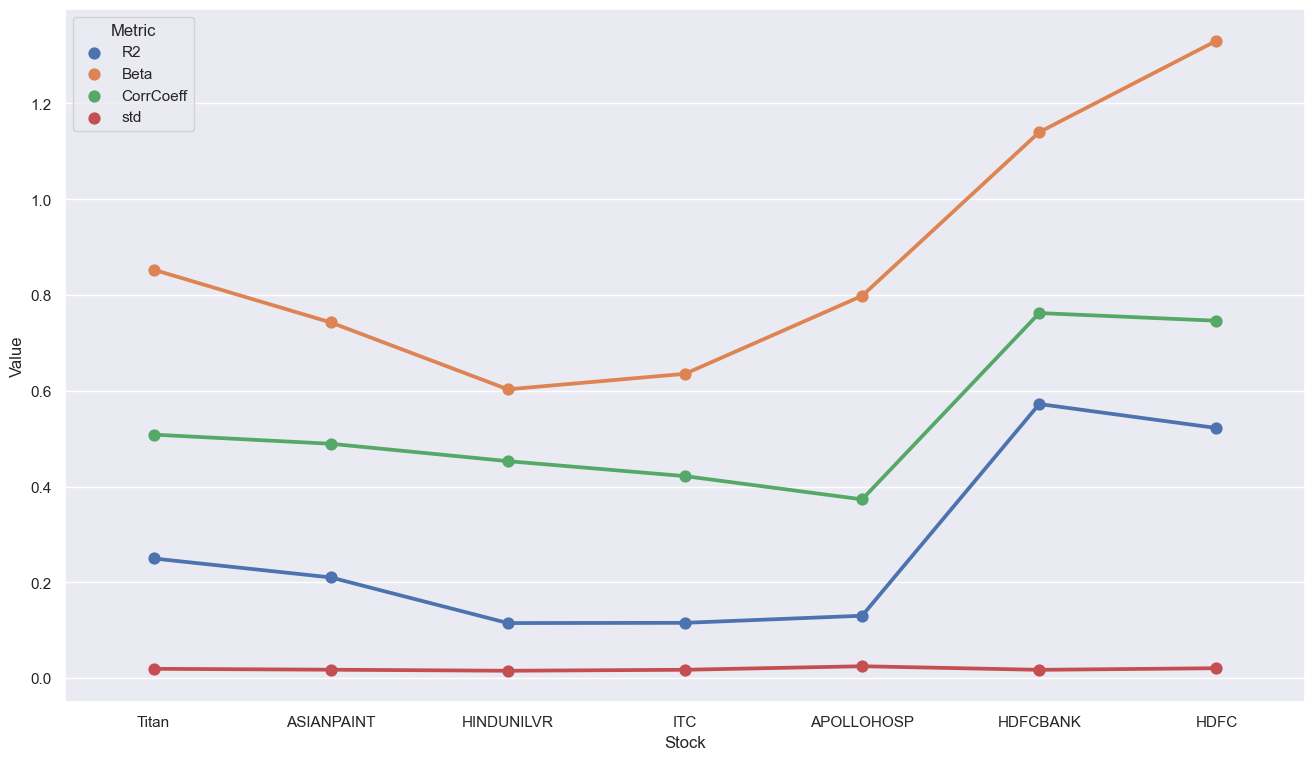

In [24]:
sns.pointplot( data=graph_df, x='Stock', y='Value', hue='Metric' )
plt.show( )